In [1]:
from multiprocessing import Pool
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import scipy.stats as scy_stats

from mathphys.functions import load, save
from apsuite.commisslib.tomography_linac import DistribReconstruction, \
    paint_convex, plot_convex, plot_lines, matrix_rotation, ScreenProcess

### Functions

In [2]:
def bivariate_gaussian(mean, cov, gridx, gridy):
    """Computes a bivariate Gaussian distribution over a grid."""
    data = np.vstack([gridx.ravel(), gridy.ravel()]).T
    vals1 = scy_stats.multivariate_normal.pdf(data, mean=mean, cov=cov)
    return vals1.reshape(*gridx.shape)


def rotates_distribution(points, angles):
    """."""
    rotm = matrix_rotation(angles)
    new_points = np.einsum("ijk,jl->kil", rotm, points)
    return new_points


def get_projections(gridx, gridy, hists, proj_axis="x", threshold=1e-5):
    """Computes projections of 2D histograms along a specified axis.

    Args:
    gridx (array): Grid of x-coordinates.
    gridy (array): Grid of y-coordinates.
    hists (list of arrays): List of 2D histograms to project.
    proj_axis (str): Axis to project onto ("x" or "y").
    threshold (float): Minimum value to include in the projection.

    Returns:
    tuple:
        - projs_list (list of arrays): Projected histograms.
        - bins_list (list of arrays): Bin edges for each projection.
        - bins_size (list of floats): Bin sizes for each projection.
    """
    if proj_axis == "x":
        axis = 0
        delta_proj = gridy[1, 0] - gridy[0, 0]
        delta_bin = gridx[0, 1] - gridx[0, 0]
    else:
        axis = 1
        delta_proj = gridx[0, 1] - gridx[0, 0]
        delta_bin = gridy[1, 0] - gridy[0, 0]

    projs_list = []
    bins_list = []
    bins_size = []
    for hist in hists:
        # hist sum must be normalized to one
        proj = integrate.trapezoid(hist, dx=delta_proj, axis=axis)
        mask = proj > threshold
        first_true_idx = np.argmax(mask)
        last_true_idx = len(mask) - np.argmax(mask[::-1]) - 1
        idcs = np.arange(len(mask))
        mask = (idcs >= first_true_idx) & (idcs <= last_true_idx)

        proj = proj[mask]
        pos = gridx[0, mask] if proj_axis == "x" else gridy[mask, 0]
        min_bin = pos[0] - delta_bin / 2
        max_bin = pos[-1] + delta_bin / 2

        bins_list.append(np.arange(min_bin, max_bin + delta_bin, delta_bin))
        projs_list.append(proj)
        bins_size.append(delta_bin)

    return projs_list, bins_list, bins_size


def interpolate_distrib_in_cvxs(
    distrib_in_grid,
    cvx_centroids,
    cvx_areas,
    points,
):
    """Interpolates a distribution in a convex grid.

    The distribtuion was first defined in a regular grid, but is being fitted
    in a convex grid.
    """
    distrib_itp = interpolate.griddata(
        points, distrib_in_grid, cvx_centroids, fill_value=0
    )
    return distrib_itp / np.sum(distrib_itp * cvx_areas)


def interpolate_distrib_in_grid(
    distrib_in_cvxs,
    cvx_centroids,
    grid_area,
    points,
):
    """Interpolates a distribution in a regular grid.

    The distribtuion was first difined in a convex grid, but is being fitted
    in a regular grid.
    """
    distrib_itp = interpolate.griddata(
        cvx_centroids, distrib_in_cvxs, points, fill_value=0
    )
    return distrib_itp / np.sum(distrib_itp) / grid_area


def difference_btw_distributions(distrib_ini, distrib_rec, areas):
    """."""
    diff_distribs = distrib_ini - distrib_rec
    diff_distribs = np.sum(diff_distribs * diff_distribs * areas)
    constant = np.sum(distrib_ini * distrib_ini * areas)
    diff_distribs = np.sqrt(diff_distribs / constant)
    return diff_distribs


def plot_distrib_in_grid(fig, ax, gridx, gridy, distrib, p_nr, **kwargs):
    """Plot a distribution defined in a regular grid."""
    hist = distrib.copy()
    hist[hist > 0] = np.power(hist[hist > 0], p_nr)
    hist += np.min(hist)
    hist /= hist.max()
    ax.pcolormesh(gridx, gridy, hist, **kwargs)
    return fig, ax


def plot_reconstructed(
    fig, ax, convexes, rec_distrib_val, p_nr, color_map="jet"
):
    """Plot a distribution defined in a convex grid."""
    cmap = getattr(plt.cm, color_map, plt.cm.jet)
    dist = rec_distrib_val.copy()
    dist[dist > 0] = np.power(dist[dist > 0], p_nr)
    dist += np.min(dist)
    dist /= dist.max()
    color = cmap(dist)[:, :-1]
    for i, convex in enumerate(convexes):
        fig, ax = paint_convex(convex, fig=fig, ax=ax, color=color[i])
    return fig, ax

### Gaussian Distribution

In [3]:
# Coordinates
x_min, x_max = -30, 30
y_min, y_max = -30, 30
x_lim = [x_min, x_max]
y_lim = [y_min, y_max]
delta_x, delta_y = 1, 1

x_bins = np.arange(x_min, x_max + delta_x, delta_x)
y_bins = np.arange(y_min, y_max + delta_x, delta_y)
x = (x_bins[:-1] + x_bins[1:]) / 2
y = (y_bins[:-1] + y_bins[1:]) / 2
gridx, gridy = np.meshgrid(x, y)
coords = np.vstack([gridx.ravel(), gridy.ravel()])

# Distribution 1
mean_off = np.array([-19, 0]) * 0
cov_scale = 1

# Parameters
mean1 = np.array([5, -5]) + mean_off
cov1 = np.array([[100, 0], [0, 10]]) * cov_scale
rot = matrix_rotation(np.pi / 4)
cov1 = rot.T @ cov1 @ rot

mean2 = np.array([-5, 0]) + mean_off
cov2 = np.array([[100, 0], [0, 10]]) * cov_scale

mean3 = np.array([-10, -15]) + mean_off
cov3 = np.array([[5, 0], [0, 5]]) * cov_scale

# Create Distribution
z1 = bivariate_gaussian(mean1, cov1, gridx, gridy)
z2 = bivariate_gaussian(mean2, cov2, gridx, gridy)
z3 = bivariate_gaussian(mean3, cov3, gridx, gridy)

original_distrib = z1 + z2 + z3 / 4

# maxv = original_distrib.max()
# original_distrib[original_distrib < 0.3*maxv] = 0.0*maxv

proj1 = integrate.trapezoid(original_distrib, dx=delta_y, axis=1)
norm_const = integrate.trapezoid(proj1, dx=delta_x)
original_distrib /= norm_const

# # Distribution 2

# # Parameters
# mean = np.array([0, 0])
# cov = np.array([[50, 0], [0, 5]])

# # Create Distribution
# original_distrib = bivariate_gaussian(mean, cov, gridx, gridy)
# proj1 = integrate.trapezoid(original_distrib, dx=delta_y, axis=1)
# norm_const = integrate.trapezoid(proj1, dx=delta_x)
# original_distrib /= norm_const

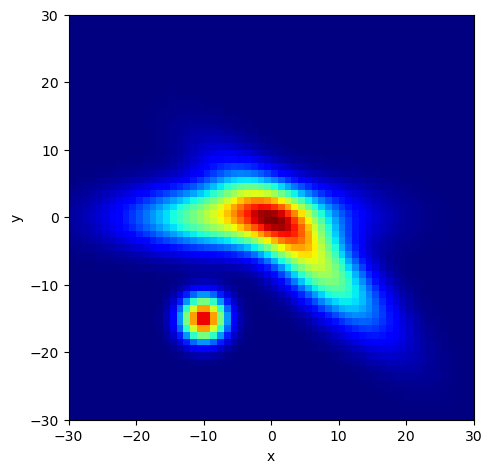

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.pcolormesh(gridx, gridy, original_distrib, cmap="jet")
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()
# fig.savefig("example_gauss_distrib.png", dpi=600)

### Histograms

In [5]:
# Rotate grid-xy applying rotation matrices
nr_angles = 3
angles = np.deg2rad(np.linspace(0, 180, nr_angles, endpoint=False))
rot_coords = rotates_distribution(coords, angles)

In [6]:
# Interpolate shrinked grid in a new rectangular grid
def process_for_interpolation(rot_coord):
    """."""
    z_val_itp = interpolate.griddata(
        rot_coord.T,
        original_distrib.ravel(),
        coords.T,
        method="linear",
        fill_value=0,
    )
    z_val_itp = z_val_itp.reshape(gridx.shape)
    proj1 = integrate.trapezoid(z_val_itp, dx=delta_y, axis=0)
    norm_const = integrate.trapezoid(proj1, dx=delta_x)
    return z_val_itp / norm_const


def parallel_process_for_interpolation(rot_coords, max_processes=4):
    """."""
    nr_processes = min(len(rot_coords), max_processes)

    with Pool(processes=nr_processes) as pool:
        hists = pool.map(process_for_interpolation, rot_coords)
    return np.array(hists)


hists = parallel_process_for_interpolation(rot_coords, max_processes=4)

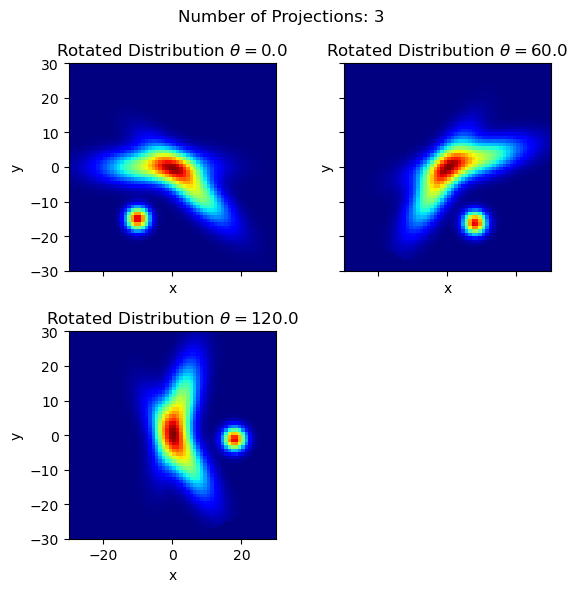

In [7]:
nr_plots = hists.shape[0]
nr_cols = 2
nr_rows = int(np.ceil(nr_plots / nr_cols))
fig, axs = plt.subplots(
    nr_rows, nr_cols, sharex=True, sharey=True, figsize=(6, 3 * nr_rows)
)

axs = axs.flat
for i, ax in enumerate(axs):
    if i < nr_plots:
        ax.pcolormesh(gridx, gridy, hists[i], cmap="jet")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        angle = np.round(np.rad2deg(angles[i]))
        ax.set_title(rf"Rotated Distribution $\theta={angle}$")
        ax.set_aspect("equal")
    else:
        ax.axis("off")
fig.suptitle(f"Number of Projections: {nr_angles}")
fig.tight_layout()

### Projections

In [19]:
projs_x, bins_x, bins_size_x = get_projections(gridx, gridy, hists)

## Add noise to the distributions
for proj in projs_x:
    proj += np.random.randn(proj.size)*proj.max()*0.02 * 0
    proj[proj<0] = 0

# Normalize projection according to bin_size
projs_x_bin = []

for i, proj in enumerate(projs_x):
    projs_x_bin.append(proj * bins_size_x[i])

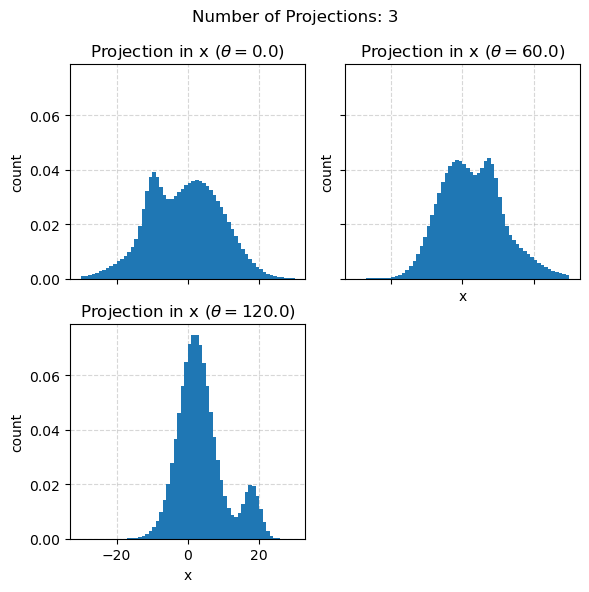

In [20]:
# plots the projection respect to each theta
nr_plots = len(projs_x)
nr_cols = 2
nr_rows = int(np.ceil(nr_plots / nr_cols))
fig, axs = plt.subplots(
    nr_rows, nr_cols, sharex=True, sharey=True, figsize=(6, 3 * nr_rows)
)

axs = axs.flat
for i, ax in enumerate(axs):
    if i < nr_plots:
        ax.grid(ls="--", alpha=0.5)
        ax.bar(
            bins_x[i][:-1],
            projs_x[i],
            width=bins_size_x[i],
            align="edge",
            zorder=2,
            color="C0",
        )
        angle = np.round(np.rad2deg(angles[i]))
        ax.set_title(rf"Projection in x $(\theta={angle})$")
        ax.set_ylabel("count")
    else:
        ax.axis("off")

if nr_plots > nr_cols:
    axs[nr_plots - nr_cols].set_xlabel("x")
axs[nr_plots - 1].set_xlabel("x")

fig.suptitle(f"Number of Projections: {nr_angles}")
fig.tight_layout()
# fig.savefig(f"projections_j{nr_angles}.png", dpi=600)

### Get Convexes

In [21]:
rot_matrices = matrix_rotation(angles)
rot_matrices = np.transpose(rot_matrices, (2, 0, 1))

dist_rec = DistribReconstruction(
    matrices=rot_matrices,
    projs=projs_x_bin,
    projs_bins=bins_x,
)

lines = dist_rec.lines
border_lines = dist_rec.border_lines
all_lines = dist_rec.raveled_lines
main_cvx = dist_rec.find_convex_from_borders([0, 0])

Text(0.5, 0.98, 'Number of Projections: 3')

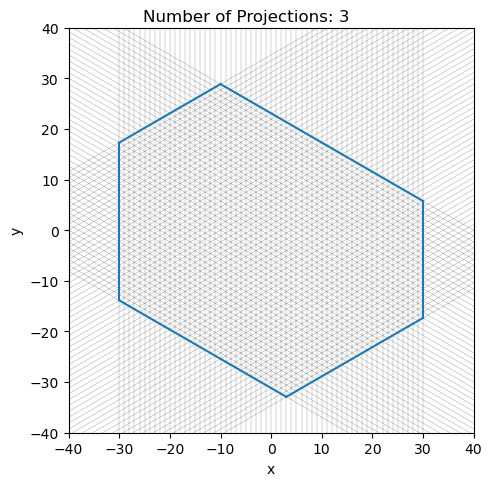

In [22]:
# Plot region for reconstruction
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

fig, ax = plot_lines(all_lines, fig=fig, ax=ax, color="k", lw=0.3, alpha=0.4)
fig, ax = plot_convex(main_cvx, fig=fig, ax=ax, ms=0, color="C0")
ax.set_aspect("equal")
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()
fig.suptitle(f"Number of Projections: {nr_angles}")
# fig.savefig(f"convex_grid_j{nr_angles}.png", dpi=600)

In [23]:
# t_convex = time()
fname = f'convexes_{nr_angles}.pickle'
if os.path.isfile(fname):
    dist_rec._convexes = load(fname)
else:
    dist_rec.subdivide_main_convex([main_cvx])
    save(dist_rec._convexes, fname, overwrite=True)
convexes_all = dist_rec.convexes
# np.savetxt(f"t_convex_j{nr_angles}.txt", [nr_angles, time() - t_convex])

### Get Distribution

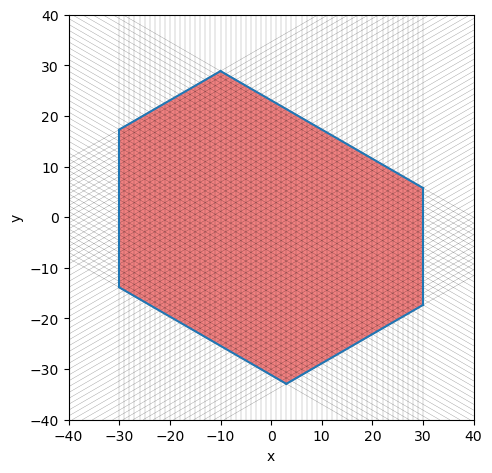

In [24]:
# Show convexes that will be used for reconstruction
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

fig, ax = plot_lines(all_lines, fig=fig, ax=ax, color="k", lw=0.3, alpha=0.4)
fig, ax = plot_convex(main_cvx, fig=fig, ax=ax, ms=0, color="C0")
convexes_nontriv = dist_rec.select_non_trivial_convexes()
for convex in convexes_nontriv.values():
    fig, ax = paint_convex(convex, fig=fig, ax=ax, color="lightcoral")
ax.set_aspect("equal")
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()

In [49]:
# t_rec = time()
dist_rec.reconstruct_distribution(
    nr_iter=500,
    tol=1e-3,
    gain=1,
    max_change=1,
    min_rchi2=1e-6,
    rcond=1e-3,
    fancy_init=True
)
# np.savetxt(f"t_rec_j{nr_angles}.txt", [nr_angles, time() - t_rec])
# save(dist_rec, f"dist_rec_j{nr_angles}")

0001/0500 -> max. rel. change= 1.84e-01, nr_svs=0136/0167, rel. chi_square= 9.72e-01
0002/0500 -> max. rel. change= 1.88e-01, nr_svs=0138/0167, rel. chi_square= 9.67e-01
0003/0500 -> max. rel. change= 1.74e-01, nr_svs=0139/0167, rel. chi_square= 9.59e-01
0004/0500 -> max. rel. change= 2.25e-01, nr_svs=0139/0167, rel. chi_square= 9.03e-01
0005/0500 -> max. rel. change= 1.72e-01, nr_svs=0140/0167, rel. chi_square= 8.90e-01
0006/0500 -> max. rel. change= 2.07e-01, nr_svs=0140/0167, rel. chi_square= 8.43e-01
0007/0500 -> max. rel. change= 2.89e-01, nr_svs=0140/0167, rel. chi_square= 6.31e-01
0008/0500 -> max. rel. change= 3.38e-01, nr_svs=0140/0167, rel. chi_square= 2.98e-01
0009/0500 -> max. rel. change= 3.03e-01, nr_svs=0140/0167, rel. chi_square= 4.69e-02
0010/0500 -> max. rel. change= 1.36e-01, nr_svs=0140/0167, rel. chi_square= 7.64e-04
0011/0500 -> max. rel. change= 1.75e-02, nr_svs=0140/0167, rel. chi_square= 1.78e-05
0012/0500 -> max. rel. change= 2.60e-04, nr_svs=0140/0167, rel. c

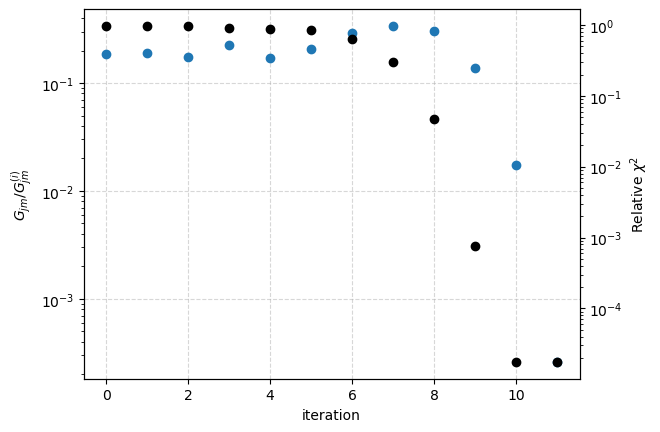

In [50]:
convergence = np.array(dist_rec.convergence_info)

fig, ax = plt.subplots(1, 1)

ax.plot(convergence[:, 0], convergence[:, 1], "o")
ay = ax.twinx()
ay.plot(convergence[:, 0], convergence[:, 3], 'ko')
ay.set_yscale('log')
ay.set_ylabel(r'Relative $\chi^2$')
ax.grid(ls="--", alpha=0.5)
ax.set_xlabel("iteration")
ax.set_ylabel(r"$G_{jm}/G_{jm}^{(i)}$")
ax.set_yscale("log")
# np.savetxt(f"convergence_j{nr_angles}.txt", convergence)

In [51]:
# Take convexes properties
convexes = np.array(list(convexes_all.values()))
areas = np.array(list(dist_rec.get_convexes_propty(propty_name="area").values()))
centroids = np.array(list(dist_rec.get_convexes_propty(propty_name="centroid").values()))
rec_distrib_val = np.array(list(dist_rec.get_convexes_propty(propty_name="distrib").values()))

Text(0.5, 0.98, 'Number of projections: 3')

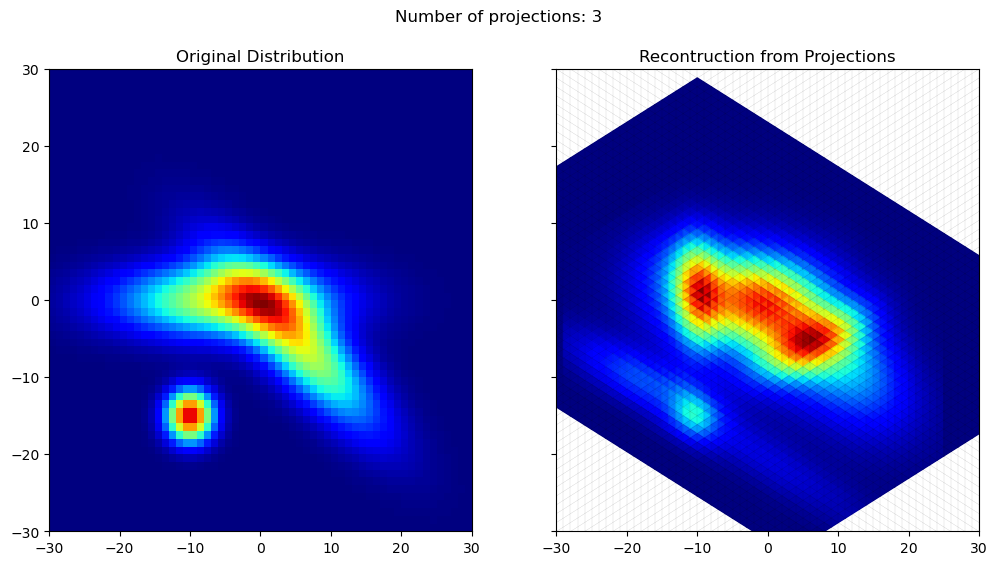

In [52]:
# Compare simulated distribution with reconstructed one
power_number = 1

fig, (ax, ay) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

fig, ax = plot_distrib_in_grid(
    fig, ax, gridx, gridy, original_distrib, power_number, cmap="jet"
)
ax.set_title("Original Distribution")

fig, ay = plot_lines(all_lines, fig=fig, ax=ay, color="k", lw=0.1, alpha=0.5)
fig, ay = plot_reconstructed(
    fig, ay, convexes, rec_distrib_val, power_number, color_map="jet"
)
ay.set_xlim(x_lim)
ay.set_ylim(y_lim)
ay.set_title("Recontruction from Projections")

fig.suptitle(f"Number of projections: {nr_angles}")
# fig.savefig(f"reconstruction_j{nr_angles}.png", dpi=600)

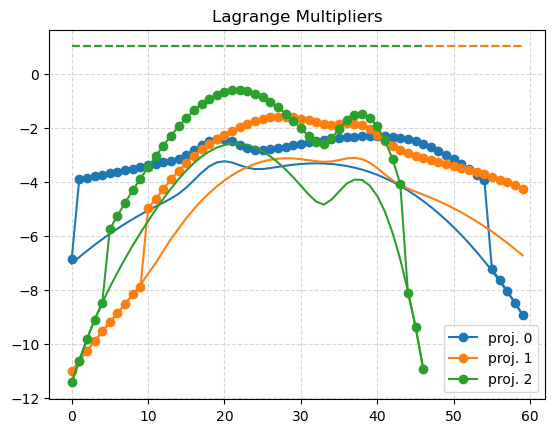

In [53]:
# Compare values of langrange multiplier
fig, ax = plt.subplots(1, 1)

init_lagmults = dist_rec.init_lagmults
for j in range(nr_angles):
    ax.plot(dist_rec.lagmults[j], "-o", label=f"proj. {j}")
    ax.plot(np.log(dist_rec._projs[j]), "-", color=f'C{j:d}')
    ax.plot(init_lagmults[j], "--", color=f'C{j:d}')
ax.set_yscale("linear")
ax.set_title("Lagrange Multipliers")
ax.grid(ls="--", alpha=0.5)
ax.legend()

Text(0, 0.5, 'y')

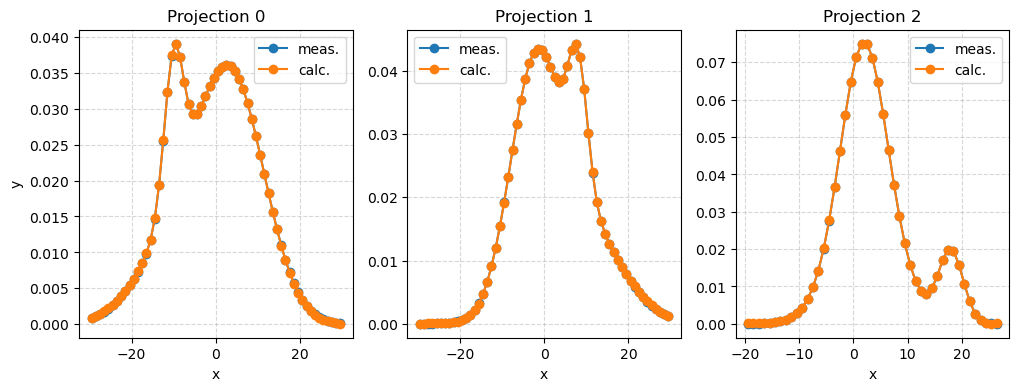

In [38]:
# Compare projections of simulated distribution and reconstructed one
projs_calc = dist_rec.get_model_projections()
nr_projs = dist_rec.nr_projs

fig, axs = plt.subplots(1, nr_projs, figsize=(4*nr_projs, 4))

for i, ax in enumerate(axs):
    x_plot = ScreenProcess.bin_to_position(bins_x[i])
    ax.plot(x_plot, projs_x_bin[i], "-o", label="meas.")
    ax.plot(x_plot, projs_calc[i], "-o", label="calc.")
    ax.legend()
    ax.set_title(f"Projection {i}")
    ax.set_xlabel("x")
    ax.grid(ls="--", alpha=0.5)
axs[0].set_ylabel("y")

Text(0.5, 1.0, 'Distribution Reconstructed in Regular Grid')

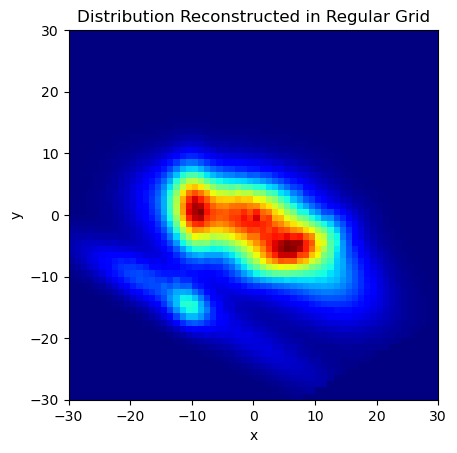

In [39]:
# Show the recosntructed distribution in a regular grid
distrib_itp = dist_rec.get_model_distrib_in_grid(gridx, gridy)

fig, ax = plt.subplots(1, 1)
dist = distrib_itp.copy()
dist += np.min(dist)
dist /= np.max(dist)
ax.pcolormesh(gridx, gridy, dist, cmap="jet")
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Distribution Reconstructed in Regular Grid")

### Compare Distributions

In [40]:
# Interpolates initial distribution in polygon's centroid
hist = original_distrib.copy()
grid_area = delta_x * delta_y
points = np.vstack([gridx.ravel(), gridy.ravel()]).T
hist_values = hist.ravel()

ini_distrib_itp = interpolate_distrib_in_cvxs(
    hist_values, centroids, areas, points
)

In [41]:
mat = []
nr_bins = dist_rec.nr_bins
zers = [np.zeros(nr) for nr in nr_bins]
for _, idcs in enumerate(dist_rec.convexes.keys()):
    m = []
    for j, zer in enumerate(zers):
        mi = zer.copy()
        mi[idcs[j]] += 1
        m.extend(mi)
    mat.append(m)
mat = np.array(mat)

dist = ini_distrib_itp.copy()
idcs = (dist > 1e-22)
dist = dist[idcs]
mat = mat[idcs]
lambs = np.linalg.lstsq(mat, np.log(dist), rcond=1e-10)[0]
lambs = np.split(lambs, np.cumsum(nr_bins)[:-1])

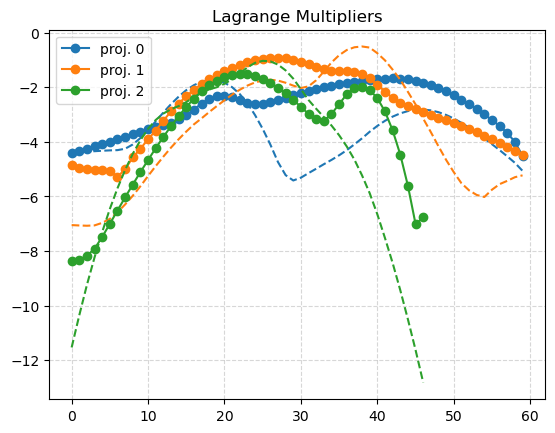

In [42]:
# Compare values of langrange multiplier
fig, ax = plt.subplots(1, 1)

for j in range(nr_angles):
    ax.plot(dist_rec.lagmults[j], "-o", label=f"proj. {j}")
    ax.plot(lambs[j], '--', color=f'C{j}')
ax.set_yscale("linear")
ax.set_title("Lagrange Multipliers")
ax.grid(ls="--", alpha=0.5)
ax.legend()

In [43]:
# Interpolates reconstructed distribution in original grid
rec_distrib_itp = interpolate_distrib_in_grid(
    rec_distrib_val, centroids, grid_area, points
)

rec_distrib_itp = rec_distrib_itp.reshape(gridx.shape)

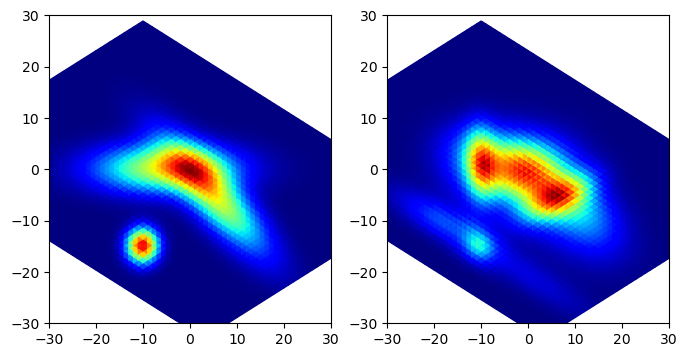

In [44]:
# Compares distributions in polygons
distributions = [ini_distrib_itp, rec_distrib_val]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for ax, distrib in zip(axs, distributions):
    jet = plt.cm.jet
    dist = distrib.copy()
    dist[dist > 0] = np.power(dist[dist > 0], 1)
    dist += np.min(dist)
    dist /= dist.max()
    color = jet(dist)[:, :-1]
    for i, convex in enumerate(convexes):
        fig, ax = paint_convex(convex, fig=fig, ax=ax, color=color[i])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

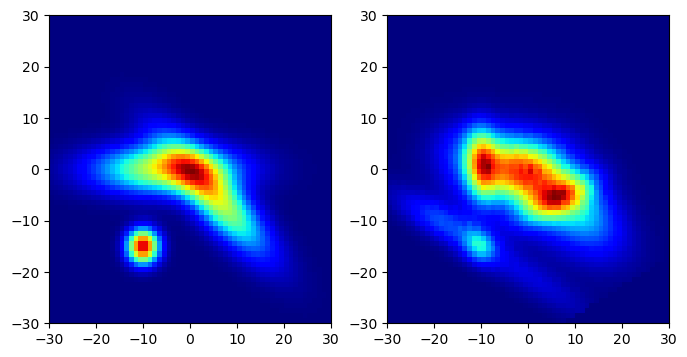

In [45]:
# Compares distributions in regular grid
distributions = [hist, rec_distrib_itp]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for i, (ax, distrib) in enumerate(zip(axs, distributions)):
    dist = distrib.copy()
    dist[dist > 0] = np.power(dist[dist > 0], 1)
    dist += np.min(dist)
    dist /= dist.max()
    ax.pcolormesh(gridx, gridy, dist, cmap="jet")

In [46]:
len_gridx = np.unique(np.diff(gridx, axis=1))[0]
len_gridy = np.unique(np.diff(gridy, axis=0))[0]
grid_area = len_gridx * len_gridy
grid_areas = np.tile(grid_area, rec_distrib_itp.size)

In [47]:
print("difference in convexes:")
diff = difference_btw_distributions(ini_distrib_itp, rec_distrib_val, areas)
print(diff)

difference in convexes:
0.3922534599909907


In [48]:
diff = difference_btw_distributions(
    hist.ravel(), rec_distrib_itp.ravel(), grid_areas
)
print("difference in regular grid:")
print(diff)
# np.savetxt(f"diff_btw_distribs_j{nr_angles}.txt", [nr_angles, diff])

difference in regular grid:
0.39540726091931583
